<a href="https://colab.research.google.com/github/kushv16/Audio-Sentiment-Analysis/blob/master/VGGish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install noisereduce

import pandas as pd
import numpy as np
import librosa
import librosa.display
import random
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import noisereduce as nr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # to avoid TensorFlow compiler flag message

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

# Define the model input shape
input_shape = (30, 200, 1)

# Define the model input layer
inputs = Input(shape=input_shape)

# Layer 1
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)

# Layer 2
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)

# Layer 3
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)

# Layer 4
x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)

# Flatten and add fully connected layers
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

# Output layer
outputs = Dense(units=7, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 200, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 30, 200, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 100, 64)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 100, 64)      256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 100, 128)      73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 50, 128)       0     

In [4]:
x_tr = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/x_tr.npy')
x_va = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/x_va.npy')
x_te = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/x_te.npy')

y_tr = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/y_tr.npy')
y_va = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/y_va.npy')
y_te = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/y_te.npy')

In [5]:
from scipy.io import wavfile


def clean_files(audio_file_path): 
  y, sr = librosa.load(audio_file_path, sr=16000)
  y_trim, _ = librosa.effects.trim(y, top_db=20)
  y_noise_rem = nr.reduce_noise(y=y_trim, sr=sr, prop_decrease=0.1, stationary=True)
  return y_noise_rem, sr


    # Define function to resize the 2D arrays
def resize_array(array):
    new_matrix = np.zeros((30,200))   # Initialize the new matrix shape with an array 30X200 of zeros
    for i in range(30):               # Iterate rows
        for j in range(200):          # Iterate columns
            try:                                 # the mfccs of a sample will replace the matrix of zeros, then cutting the array up to 200
                new_matrix[i][j] = array[i][j]
            except IndexError:                   # if mfccs of a sample is shorter than 200, then keep looping to extend lenght to 200 with 0s
                pass
    return new_matrix

In [6]:
x = np.concatenate((x_tr, x_va), axis=0)
y = np.concatenate((y_tr, y_va), axis=0)

In [7]:
np.save("/content/drive/My Drive/LY Project/x_train_val_combined.npy", x)
np.save("/content/drive/My Drive/LY Project/y_train_val_combined.npy", y)

In [8]:
x.shape, y.shape

((8408, 30, 200), (8408,))

In [9]:
tr_mean = np.mean(x, axis=0)
tr_std = np.std(x, axis=0)

In [10]:
x = (x - tr_mean)/tr_std
x = x[..., None]

In [11]:
x_te = (x_te - tr_mean)/tr_std
x_te = x_te[..., None]

In [12]:
from tensorflow import keras

# Compile the model using Adam's default learning rate
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y), y= y)
class_weights = dict(zip(np.unique(y), class_weights))

# Create 'EarlyStopping' callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [13]:
history = model.fit(
    x=x,
    y=y,
    epochs=1000,
    batch_size=32,
    validation_split=0.2,
    callbacks=[earlystopping_cb],
    class_weight=class_weights,
)

Epoch 1/1000
211/211 [==============================] - 29s 59ms/step - loss: 1.7725 - accuracy: 0.4715 - val_loss: 2.4442 - val_accuracy: 0.4251
Epoch 2/1000
211/211 [==============================] - 10s 49ms/step - loss: 1.2481 - accuracy: 0.6231 - val_loss: 0.9054 - val_accuracy: 0.6944
Epoch 3/1000
211/211 [==============================] - 11s 51ms/step - loss: 1.0294 - accuracy: 0.6876 - val_loss: 1.1252 - val_accuracy: 0.6635
Epoch 4/1000
211/211 [==============================] - 11s 51ms/step - loss: 0.9391 - accuracy: 0.7260 - val_loss: 1.1717 - val_accuracy: 0.7545
Epoch 5/1000
211/211 [==============================] - 11s 53ms/step - loss: 0.8911 - accuracy: 0.7370 - val_loss: 0.8181 - val_accuracy: 0.7545
Epoch 6/1000
211/211 [==============================] - 11s 54ms/step - loss: 0.8050 - accuracy: 0.7574 - val_loss: 0.7738 - val_accuracy: 0.7539
Epoch 7/1000
211/211 [==============================] - 11s 53ms/step - loss: 0.6533 - accuracy: 0.8052 - val_loss: 1.3379 -

In [14]:
model.save('/content/drive/My Drive/LY Project/vggish.h5')

In [15]:
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv("/content/drive/MyDrive/LY Project/vggish_history.csv")

model.save_weights("/content/drive/MyDrive/LY Project/vggish_weights.h5")

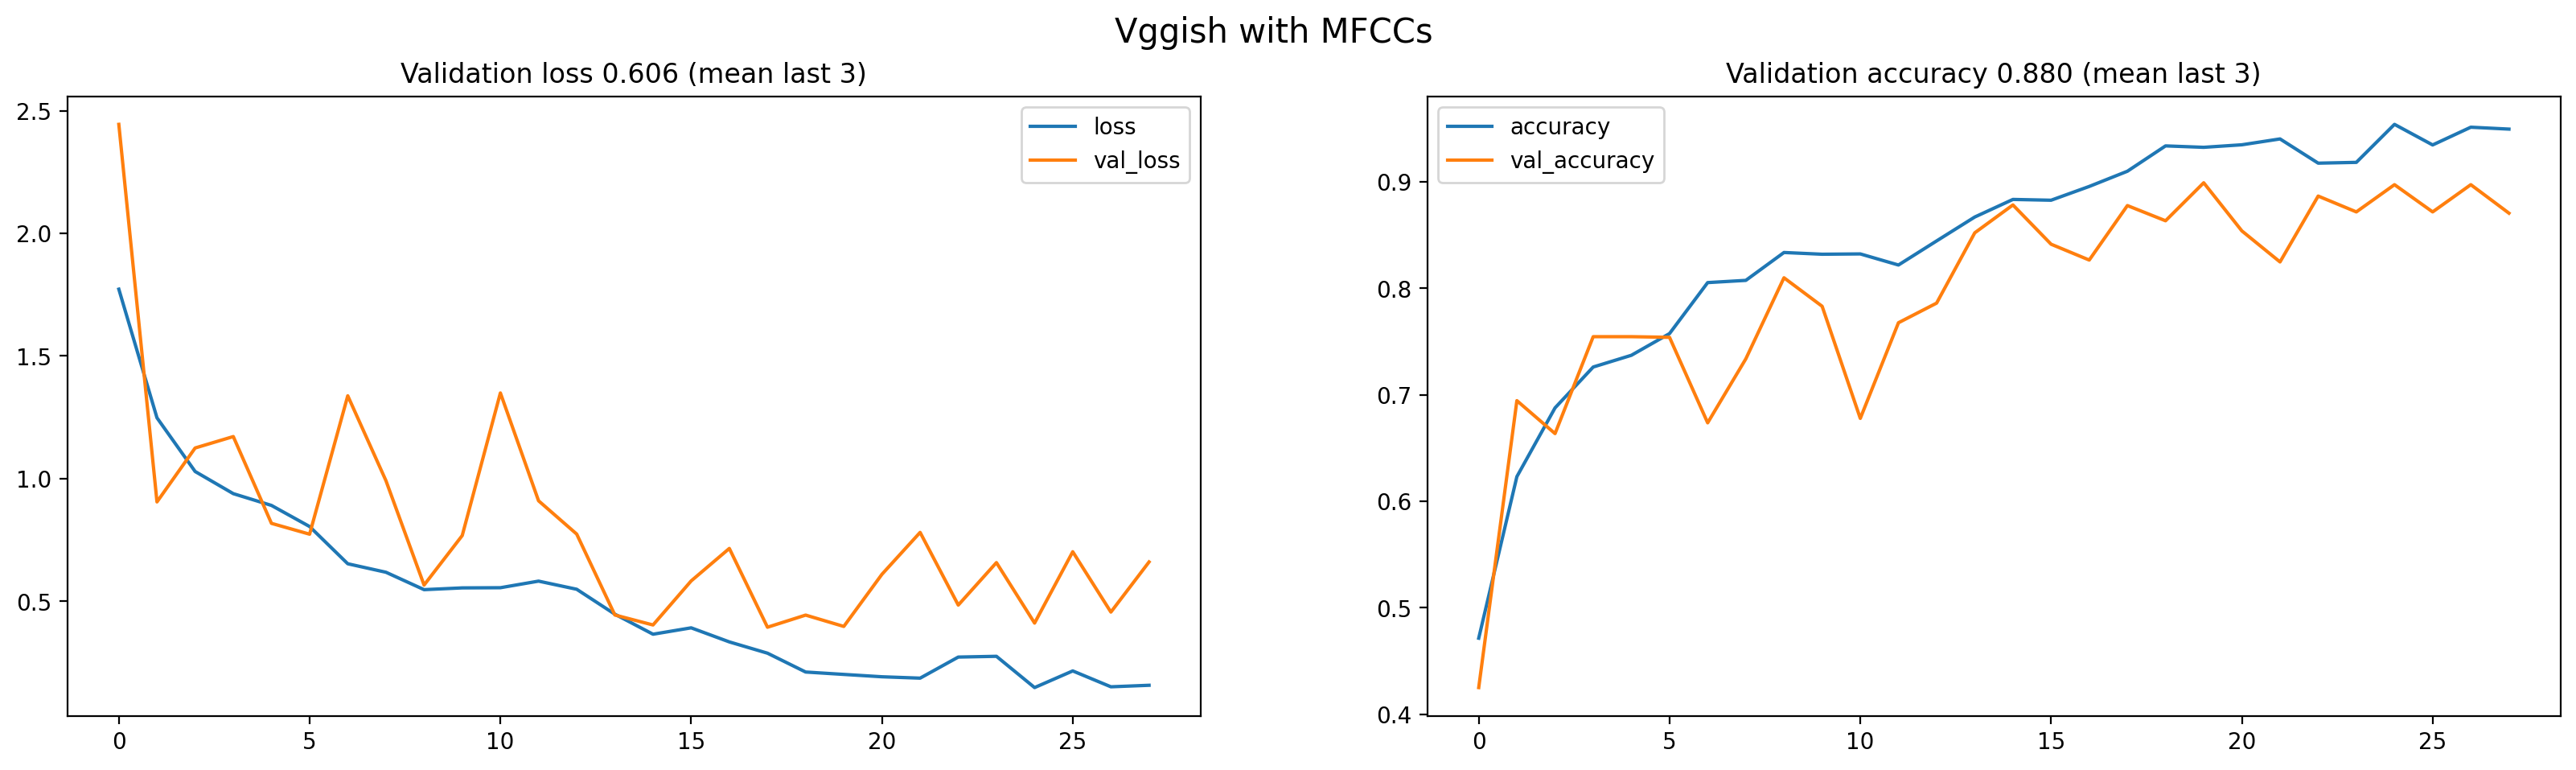

In [16]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Vggish with MFCCs', size=15)
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:])))
results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_accuracy"][-3:])))
plt.savefig("/content/drive/MyDrive/LY Project/vggish_training_curves.png")
plt.show()

In [17]:
# Collect loss and accuracy for the test set
loss_te, accuracy_te = model.evaluate(x_te, y_te)

print("Test loss: {:.2f}".format(loss_te))
print("Test accuracy: {:.2f}%".format(100 * accuracy_te))

30/30 [==============================] - 1s 26ms/step - loss: 0.3548 - accuracy: 0.8834
Test loss: 0.35
Test accuracy: 88.34%


30/30 [==============================] - 1s 12ms/step


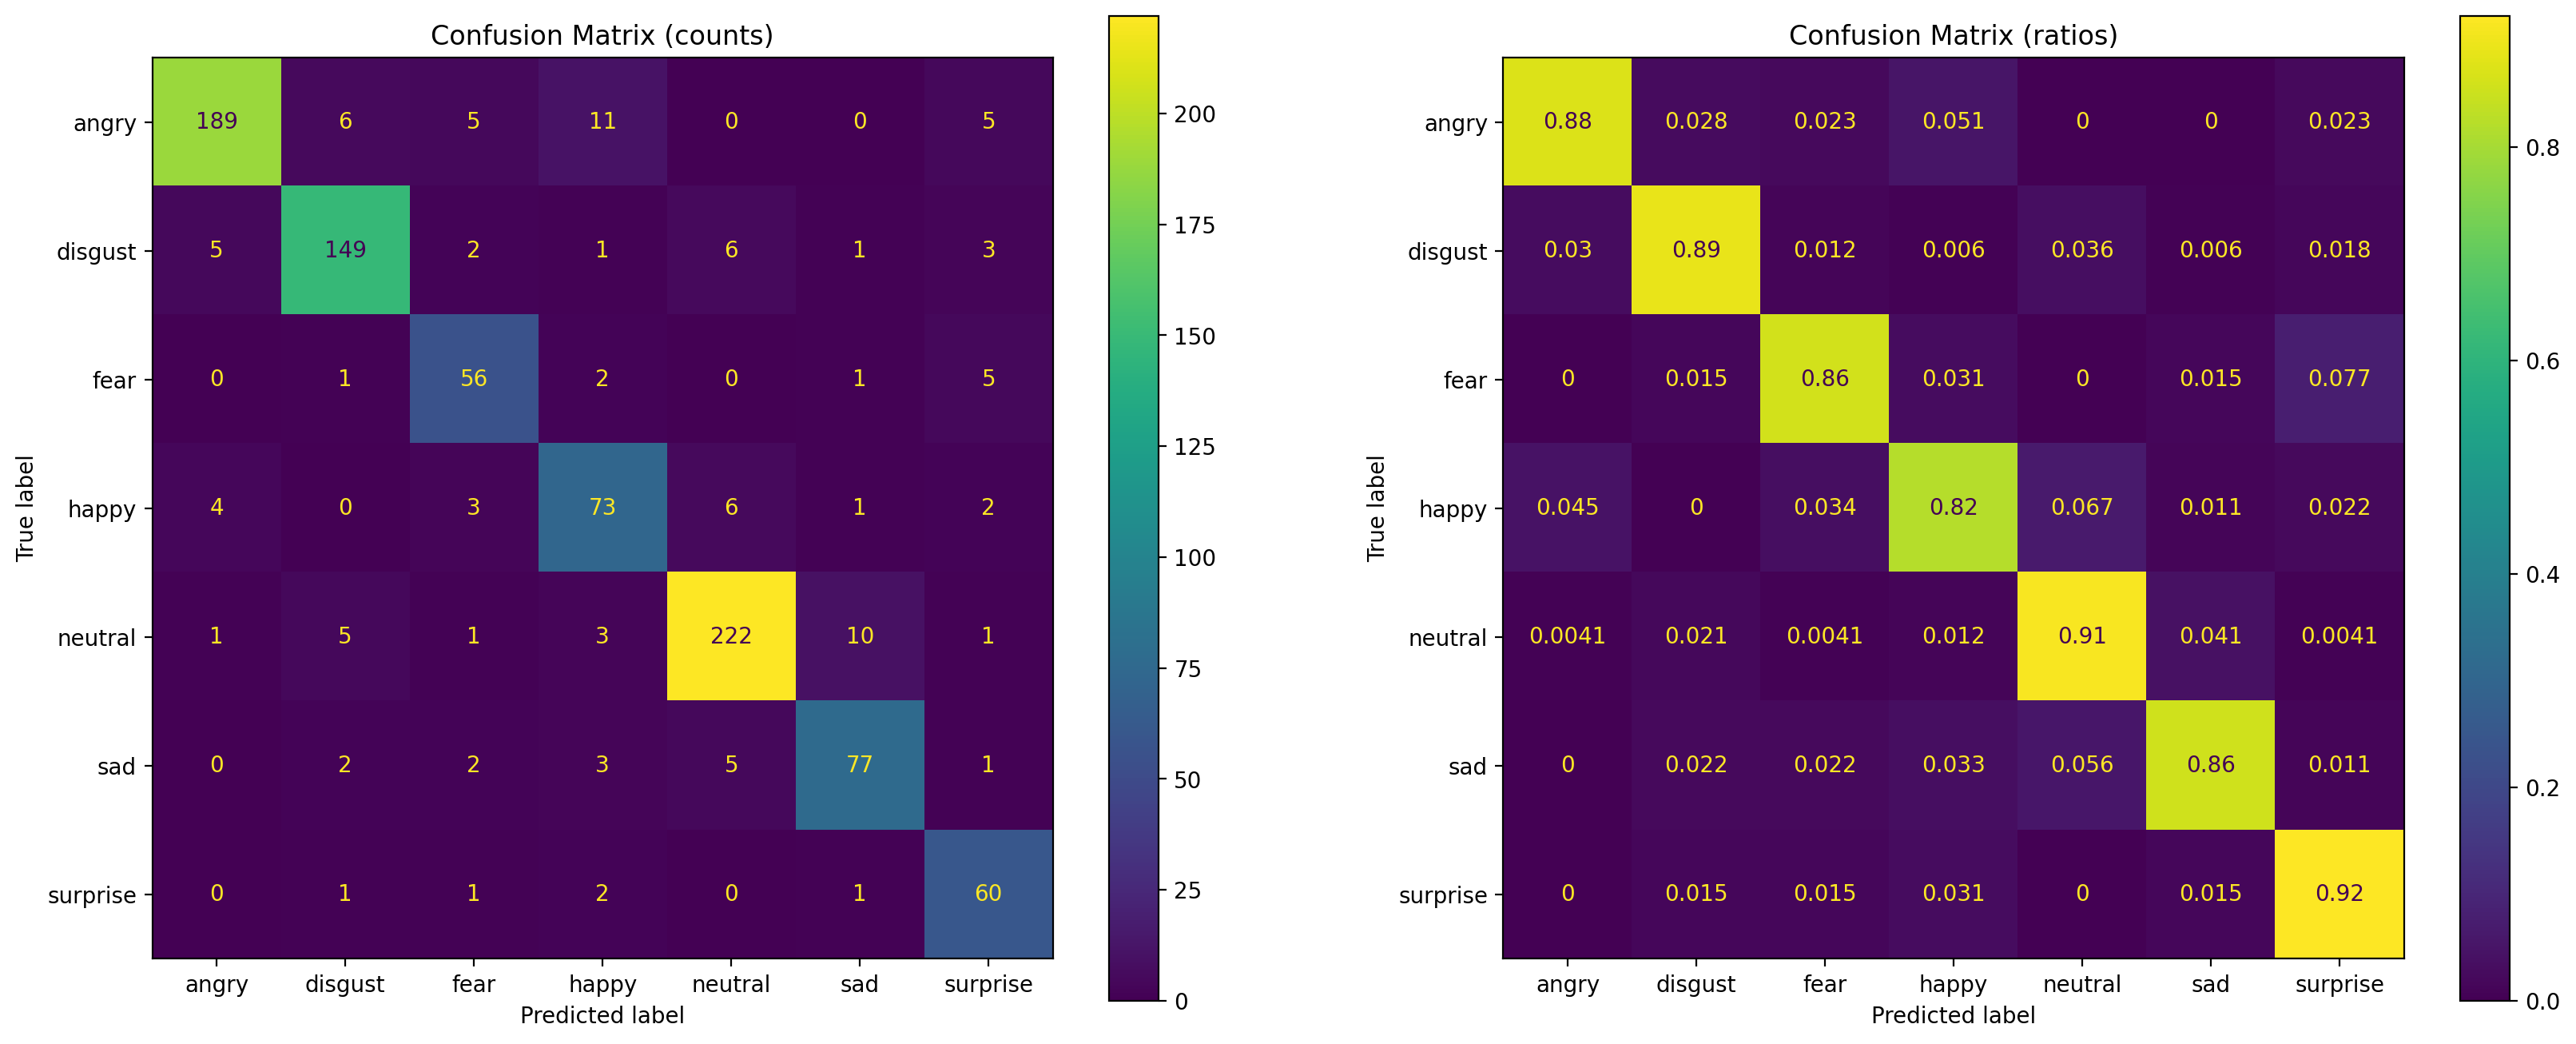

In [18]:
# Compute test set predictions
predictions = model.predict(x_te)

pred = []

for i in predictions:
    pred.append(np.argmax(i))
    
from sklearn.metrics import ConfusionMatrixDisplay

labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)
    plt.savefig("/content/drive/MyDrive/LY Project/vggish_confusion_matrices.png")
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, pred)